# Æther: Moden Code Plagiarism Detection with CodeBERTa

This notebook implements a robust pipeline for detecting code plagiarism using the CodeBERTa model and multiple similarity metrics.


## 1. Configuration


In [21]:
import os
import time
import gc
import logging
import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import (
    Dict,
    List,
    Tuple,
    Optional,
    Any,
    Union,
    Callable,
    TypeVar,
    Generic,
    cast,
)
from functools import lru_cache, partial
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer,
    RobertaModel,
    PreTrainedTokenizer,
    PreTrainedModel,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from tqdm.auto import tqdm
import Levenshtein

### 1.1 Setup Logging


In [23]:
logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
)

logger = logging.getLogger(__name__)

### 1.2 Suppress Warnings & Configure Plot Styles


In [24]:
warnings.filterwarnings("ignore")

In [25]:
plt.style.use("fivethirtyeight")
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

### 1.3 Type Hints


In [26]:
T = TypeVar("T")
ModelType = TypeVar("ModelType", bound=PreTrainedModel)
TokenizerType = TypeVar("TokenizerType", bound=PreTrainedTokenizer)

### 1.4 Configuration


In [27]:
@dataclass
class Config:
    """Configuration for the plagiarism detection pipeline."""

    # Paths - Define as static values first
    BASE_PATH: Path = Path("../../")
    RESULTS_PATH: Path = Path("./results")
    CACHE_DIR: Path = Path("./cache")
    DATASET_PATH: Path = BASE_PATH / "datasets" / "conplag_preprocessed"
    LABELS_PATH: Path = BASE_PATH / "labels"

    # Model Configuration
    MODEL_NAME: str = "huggingface/CodeBERTa-small-v1"
    MAX_LENGTH: int = 512
    BATCH_SIZE: int = 16
    NUM_WORKERS: int = field(
        default_factory=lambda: max(1, multiprocessing.cpu_count() // 2)
    )
    CACHE_SIZE: int = 1024

    # Important flags
    USE_FP16: bool = False
    SKIP_MISSING_FILES: bool = False
    FILE_EXTENSIONS = [".java"]

    # Memory optimization
    CLEAR_CUDA_CACHE: bool = True
    BATCH_PROCESSING: bool = True
    MAX_BATCH_SIZE_OVERRIDE: int = 4

    # File handling options
    DEBUG_FILE_PATHS: bool = True
    DETAILED_LOGGING: bool = True

    # Similarity configuration
    SIMILARITY_WEIGHTS: Tuple[float, float, float] = (
        0.6,
        0.2,
        0.2,
    )  # (bert, edit, token)
    SIMILARITY_TIMEOUT: int = 10

    # Metrics visualization
    SAVE_VISUALIZATIONS: bool = True

    @classmethod
    def initialize(cls) -> None:
        """
        Initialize configuration
        """

        for directory in [cls.RESULTS_PATH, cls.CACHE_DIR]:
            directory.mkdir(exist_ok=True, parents=True)

        if torch.cuda.is_available():
            torch.backends.cudnn.benchmark = True
            logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")

        else:
            logger.info("GPU not available, using CPU")

        torch.set_grad_enabled(False)

## 2. CodePair


In [28]:
@dataclass
class CodePair:
    """
    Represents a pair of code samples with their metadata and similarity.
    """

    id1: str
    id2: str
    problem: str
    label: int
    code1: Optional[str] = None
    code2: Optional[str] = None
    embedding1: Optional[torch.Tensor] = None
    embedding2: Optional[torch.Tensor] = None
    similarity: Optional[float] = None

    def to_dict(self) -> Dict[str, Any]:
        """
        Convert to dictionary for results storage.
        """

        return {
            "id1": self.id1,
            "id2": self.id2,
            "problem": self.problem,
            "label": self.label,
            "similarity": (
                self.similarity if self.similarity is not None else float("nan")
            ),
        }

## 3. File Utils


In [29]:
class FileUtils:
    """
    Utilities for file operations with caching and error handling.
    """

    @staticmethod
    def find_file_with_extensions(
        base_path: Path, file_id: str, extensions: List[str]
    ) -> Optional[Path]:
        """
        Find a file with any of the given extensions.

        Args:
            base_path: Base directory to search in
            file_id: File identifier (without extension)
            extensions: List of possible file extensions to try

        Returns:
            Path to the file if found, None otherwise
        """

        for ext in extensions:
            file_path = base_path / f"{file_id}{ext}"

            if file_path.exists():
                if Config.DEBUG_FILE_PATHS:
                    logger.debug(f"Found file at: {file_path}")
                return file_path

        if Config.DEBUG_FILE_PATHS:
            logger.warning(
                f"File not found for ID: {file_id} in directory: {base_path}"
            )

            available_files = list(base_path.glob("*"))[:10]
            logger.debug(f"Sample of available files: {available_files}")

        return None

    @staticmethod
    @lru_cache(maxsize=Config.CACHE_SIZE)
    def load_code_from_file(file_path: str) -> str:
        """
        Load code from file with caching for faster repeated access.

        Args:
            file_path: Path to the file to read

        Returns:
            File contents as string, or empty string on error
        """

        try:
            with open(file_path, "r", encoding="utf-8") as f:
                return f.read()

        except UnicodeDecodeError:
            try:
                with open(file_path, "r", encoding="latin-1") as f:
                    return f.read()

            except Exception as e:
                logger.warning(f"Error loading {file_path} with latin-1 encoding: {e}")
                return ""

        except FileNotFoundError:
            logger.warning(f"File not found: {file_path}")
            return "// Empty file or file not found"

        except Exception as e:
            logger.warning(f"Error loading {file_path}: {e}")
            return ""

    @staticmethod
    def scan_dataset_directory(dataset_path: Path) -> Dict[str, int]:
        """
        Scan the dataset directory to understand its structure.

        Args:
            dataset_path: Path to the dataset directory

        Returns:
            Dictionary with file extension counts
        """

        logger.info(f"Scanning dataset directory: {dataset_path}")
        if not dataset_path.exists():
            logger.error(f"Dataset path does not exist: {dataset_path}")
            return {}

        file_counts, total_files = {}, 0
        for item in dataset_path.iterdir():
            if item.is_file():
                total_files += 1
                ext = item.suffix

                if ext in file_counts:
                    file_counts[ext] += 1
                else:
                    file_counts[ext] = 1

        logger.info(f"Found {total_files} files in dataset directory")
        logger.info(f"File extension counts: {file_counts}")

        sample_files = list(dataset_path.glob("*"))[:5]
        logger.info(f"Sample files: {sample_files}")

        return file_counts

    @staticmethod
    def load_labels(csv_path: Path) -> pd.DataFrame:
        """
        Load and process label dataset.

        Args:
            csv_path: Path to the CSV file with labels

        Returns:
            DataFrame with processed labels

        Raises:
            FileNotFoundError: If the labels file doesn't exist
        """

        if not csv_path.exists():
            raise FileNotFoundError(f"Labels file not found: {csv_path}")

        df = pd.read_csv(csv_path)
        logger.info(f"Loaded {len(df)} labeled code pairs from {csv_path}")

        if "id1" in df.columns and not pd.api.types.is_string_dtype(df["id1"]):
            df["id1"] = df["id1"].astype(str)

        if "id2" in df.columns and not pd.api.types.is_string_dtype(df["id2"]):
            df["id2"] = df["id2"].astype(str)

        if "plagio" in df.columns:
            df["plagio"] = df["plagio"].astype(int)

        return df

## 4.0 Dataset


In [30]:
class PlagiarismDataset(Dataset):
    """
    Dataset for code pairs with efficient loading and caching.
    """

    def __init__(
        self,
        labels_df: pd.DataFrame,
        dataset_path: Path,
        tokenizer: PreTrainedTokenizer,
        max_length: int = 512,
    ):
        """
        Initialize the dataset.

        Args:
            labels_df: DataFrame with code pair labels
            dataset_path: Path to the directory with code files
            tokenizer: Tokenizer for encoding code
            max_length: Maximum sequence length for tokenization
        """

        self.labels_df = labels_df
        self.dataset_path = dataset_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.code_cache: Dict[str, str] = {}

        if not self.dataset_path.exists():
            logger.warning(f"Dataset path does not exist: {self.dataset_path}")

    def __len__(self) -> int:
        """
        Get the number of code pairs in the dataset.
        """

        return len(self.labels_df)

    def _get_code(self, file_id: str) -> str:
        """
        Get code with memory-efficient caching.

        Args:
            file_id: Identifier for the code file (without extension)

        Returns:
            Contents of the code file as string
        """

        if file_id in self.code_cache:
            return self.code_cache[file_id]

        file_path = FileUtils.find_file_with_extensions(
            self.dataset_path, file_id, Config.FILE_EXTENSIONS
        )

        if file_path is None:
            if Config.SKIP_MISSING_FILES:
                logger.warning(f"File not found: {file_id}")
                return "// Empty file or file not found"

            else:
                raise FileNotFoundError(f"File not found: {file_id}")

        code = FileUtils.load_code_from_file(str(file_path))

        if len(code) < 50000:
            self.code_cache[file_id] = code

        return code

    def _tokenize(self, text: str) -> Dict[str, torch.Tensor]:
        """
        Tokenize a single text efficiently.

        Args:
            text: Text to tokenize

        Returns:
            Dictionary with tokenized inputs
        """

        return self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Get a single code pair with its tokenized representations.

        Args:
            idx: Index of the item to get

        Returns:
            Dictionary with tokenized inputs and metadata
        """

        row = self.labels_df.iloc[idx]
        code1_id = row["id1"]
        code2_id = row["id2"]

        try:
            code1 = self._get_code(code1_id)
            code2 = self._get_code(code2_id)

            inputs1 = self._tokenize(code1)
            inputs2 = self._tokenize(code2)

            for key in inputs1:
                inputs1[key] = inputs1[key].squeeze(0)

            for key in inputs2:
                inputs2[key] = inputs2[key].squeeze(0)

            label = torch.tensor(row["plagio"], dtype=torch.float)

            return {
                "code1_input_ids": inputs1["input_ids"],
                "code1_attention_mask": inputs1["attention_mask"],
                "code2_input_ids": inputs2["input_ids"],
                "code2_attention_mask": inputs2["attention_mask"],
                "label": label,
                "id1": row["id1"],
                "id2": row["id2"],
                "problem": row.get("problem", "unknown"),
                "code1": code1,
                "code2": code2,
            }

        except Exception as e:
            logger.error(f"Error processing item {idx} ({code1_id}, {code2_id}): {e}")
            return {}

## 5. Model Handler


In [31]:
class ModelHandler:
    """
    Handles model loading and inference.
    """

    @staticmethod
    def load_model() -> Tuple[RobertaTokenizer, RobertaModel]:
        """
        Load the CodeBERTa model with optimizations.

        Returns:
            Tuple of (tokenizer, model)

        Raises:
            RuntimeError: If model loading fails
        """

        try:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            tokenizer = RobertaTokenizer.from_pretrained(Config.MODEL_NAME)
            model = RobertaModel.from_pretrained(
                Config.MODEL_NAME, torchscript=True, return_dict=True
            )

            model = model.to(device)
            model.eval()

            if Config.USE_FP16 and torch.cuda.is_available():
                model = model.half()

            return tokenizer, model

        except Exception as e:
            logger.error(f"Error loading model: {e}")
            raise RuntimeError(f"Failed to load model: {e}")

    @staticmethod
    @torch.no_grad()
    def get_code_embedding(
        model: RobertaModel, input_ids: torch.Tensor, attention_mask: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute code embedding efficiently.

        Args:
            model: The CodeBERTa model
            input_ids: Token IDs from tokenizer
            attention_mask: Attention mask from tokenizer

        Returns:
            Embedding tensor
        """

        device = next(model.parameters()).device

        try:
            if input_ids.dim() == 1:
                input_ids = input_ids.unsqueeze(0)

            if attention_mask.dim() == 1:
                attention_mask = attention_mask.unsqueeze(0)

            input_ids = input_ids.to(device, dtype=torch.long)
            attention_mask = attention_mask.to(device, dtype=torch.float)
            outputs = model(input_ids, attention_mask=attention_mask)

            if isinstance(outputs, tuple):
                embedding = outputs[0][:, 0, :]

            else:
                embedding = outputs.last_hidden_state[:, 0, :]

            return embedding
        except Exception as e:
            logger.error(f"Error in get_code_embedding: {e}")
            return torch.zeros(model.config.hidden_size, device=device)

## 6. Similarity Metrics


In [32]:
class SimilarityMetrics:
    """
    Different similarity metrics for code comparison.
    """

    @staticmethod
    def get_bert_similarity(
        code1: str,
        code2: str,
        model: RobertaModel,
        tokenizer: RobertaTokenizer,
        device: torch.device,
    ) -> float:
        """
        Calculate semantic similarity using BERT embeddings.

        Args:
            code1: First code string
            code2: Second code string
            model: CodeBERTa model
            tokenizer: CodeBERTa tokenizer
            device: Device to run model on

        Returns:
            Cosine similarity score (0-1)
        """

        try:
            inputs1 = tokenizer(
                code1,
                return_tensors="pt",
                truncation=True,
                max_length=Config.MAX_LENGTH,
                padding="max_length",
            ).to(device)

            inputs2 = tokenizer(
                code2,
                return_tensors="pt",
                truncation=True,
                max_length=Config.MAX_LENGTH,
                padding="max_length",
            ).to(device)

            with torch.no_grad():
                outputs1 = model(**inputs1)
                outputs2 = model(**inputs2)

                if isinstance(outputs1, tuple):
                    emb1 = outputs1[0][:, 0, :]
                    emb2 = outputs2[0][:, 0, :]

                else:
                    emb1 = outputs1.last_hidden_state[:, 0, :]
                    emb2 = outputs2.last_hidden_state[:, 0, :]

                return F.cosine_similarity(emb1, emb2).item()

        except Exception as e:
            logger.error(f"BERT similarity error: {e}")
            return 0.0

    @staticmethod
    def get_edit_similarity(code1: str, code2: str) -> float:
        """
        Calculate edit distance-based similarity.

        Args:
            code1: First code string
            code2: Second code string

        Returns:
            Edit distance-based similarity score (0-1)
        """

        try:
            if not code1 and not code2:
                return 1.0

            max_len = max(len(code1), len(code2))
            if max_len == 0:
                return 1.0

            return 1 - (Levenshtein.distance(code1, code2) / max_len)

        except Exception as e:
            logger.error(f"Edit similarity error: {e}")
            return 0.0

    @staticmethod
    def get_token_similarity(code1: str, code2: str) -> float:
        """
        Calculate token-based Jaccard similarity.

        Args:
            code1: First code string
            code2: Second code string

        Returns:
            Jaccard similarity score (0-1)
        """

        try:
            tokens1 = set(code1.split())
            tokens2 = set(code2.split())

            if not tokens1 and not tokens2:
                return 1.0

            intersection = len(tokens1 & tokens2)
            union = len(tokens1 | tokens2)

            return intersection / union if union else 0.0

        except Exception as e:
            logger.error(f"Token similarity error: {e}")
            return 0.0

    @staticmethod
    def concurrent_similarity(
        similarity_func: Callable[..., float],
        code1: str,
        code2: str,
        *args: Any,
        timeout: int = 10,
        executor: Optional[ThreadPoolExecutor] = None,
    ) -> float:
        """
        Run a similarity function in a separate thread with timeout.

        Args:
            similarity_func: The similarity function to run
            code1: First code string
            code2: Second code string
            args: Additional arguments for the similarity function
            timeout: Maximum time to wait (seconds)
            executor: Existing executor to use (or None to create a new one)

        Returns:
            Similarity score (0-1)
        """
        try:
            close_executor = executor is None
            if close_executor:
                executor = ThreadPoolExecutor(max_workers=1)

            future = executor.submit(similarity_func, code1, code2, *args)
            result = future.result(timeout=timeout)

            if close_executor:
                executor.shutdown(wait=False)

            return result

        except Exception as e:
            logger.error(
                f"Error in concurrent similarity ({similarity_func.__name__}): {e}"
            )

            return 0.0

    @staticmethod
    def ensemble_similarity(
        code1: str,
        code2: str,
        model: RobertaModel,
        tokenizer: RobertaTokenizer,
        device: torch.device,
        weights: Tuple[float, float, float] = (0.6, 0.2, 0.2),
        use_concurrent: bool = True,
        timeout: int = 10,
    ) -> float:
        """
        Compute weighted ensemble similarity score using multiple methods.

        Args:
            code1: First code string
            code2: Second code string
            model: CodeBERTa model
            tokenizer: CodeBERTa tokenizer
            device: Device to run model on
            weights: [bert_weight, edit_weight, token_weight]
            use_concurrent: Whether to use concurrent processing
            timeout: Maximum time (seconds) to wait for similarity calculations

        Returns:
            Normalized similarity score (0-1)
        """

        if not code1 or not code2:
            logger.warning("Empty code samples provided to similarity function")
            return 0.0
        
        weights_array = np.array(weights) / sum(weights)

        try:
            if not use_concurrent:
                bert_sim = SimilarityMetrics.get_bert_similarity(
                    code1, code2, model, tokenizer, device
                )
                edit_sim = SimilarityMetrics.get_edit_similarity(code1, code2)
                token_sim = SimilarityMetrics.get_token_similarity(code1, code2)

            else:
                with ThreadPoolExecutor(max_workers=3) as executor:
                    bert_future = executor.submit(
                        SimilarityMetrics.get_bert_similarity,
                        code1,
                        code2,
                        model,
                        tokenizer,
                        device,
                    )

                    edit_future = executor.submit(
                        SimilarityMetrics.get_edit_similarity, code1, code2
                    )

                    token_future = executor.submit(
                        SimilarityMetrics.get_token_similarity, code1, code2
                    )

                    from concurrent.futures import wait

                    all_futures = [bert_future, edit_future, token_future]
                    done, not_done = wait(all_futures, timeout=timeout)

                    for future in not_done:
                        future.cancel()
                        logger.warning(f"A similarity calculation timed out")

                    bert_sim = bert_future.result() if bert_future in done else 0.0
                    edit_sim = edit_future.result() if edit_future in done else 0.0
                    token_sim = token_future.result() if token_future in done else 0.0

            if Config.DETAILED_LOGGING:
                logger.debug(
                    f"Similarity scores - BERT: {bert_sim:.4f}, "
                    f"Edit: {edit_sim:.4f}, Token: {token_sim:.4f}"
                )

            return (
                weights_array[0] * bert_sim
                + weights_array[1] * edit_sim
                + weights_array[2] * token_sim
            )

        except Exception as e:
            logger.error(f"Error in ensemble similarity calculation: {e}")
            return 0.0

## 7.0 Metrics Evaluator


In [33]:
class MetricsEvaluator:
    """Evaluates plagiarism detection performance."""

    @staticmethod
    def validate_results(results: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Filter out results with invalid similarity scores.

        Args:
            results: List of result dictionaries

        Returns:
            Filtered list with only valid results
        """
        valid_results = []
        for r in results:
            if r.get("similarity") is not None and not (
                isinstance(r["similarity"], float) and np.isnan(r["similarity"])
            ):
                valid_results.append(r)

            else:
                logger.warning(
                    f"Invalid similarity score for pair {r['id1']}-{r['id2']}"
                )

        return valid_results

    @staticmethod
    def compute_metrics(
        results: List[Dict[str, Any]], threshold: float = 0.5
    ) -> Dict[str, float]:
        """
        Compute evaluation metrics with validation.

        Args:
            results: List of result dictionaries
            threshold: Threshold for binary classification

        Returns:
            Dictionary with computed metrics
        """

        valid_results = MetricsEvaluator.validate_results(results)
        if not valid_results:
            logger.error("No valid results for metrics calculation")
            return {
                "accuracy": 0.0,
                "precision": 0.0,
                "recall": 0.0,
                "f1": 0.0,
                "roc_auc": 0.0,
                "pr_auc": 0.0,
                "threshold": threshold,
            }

        labels = [r["label"] for r in valid_results]
        similarities = [r["similarity"] for r in valid_results]
        predictions = [(s > threshold) * 1.0 for s in similarities]

        try:
            accuracy = accuracy_score(labels, predictions)
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, predictions, average="binary", zero_division=0
            )

            # ROC AUC
            fpr, tpr, _ = roc_curve(labels, similarities)
            roc_auc = auc(fpr, tpr)

            # PR AUC
            precision_curve, recall_curve, _ = precision_recall_curve(
                labels, similarities
            )
            pr_auc = auc(recall_curve, precision_curve)

            return {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc,
                "pr_auc": pr_auc,
                "threshold": threshold,
            }

        except Exception as e:
            logger.error(f"Error computing metrics: {e}")
            return {
                "accuracy": 0.0,
                "precision": 0.0,
                "recall": 0.0,
                "f1": 0.0,
                "roc_auc": 0.0,
                "pr_auc": 0.0,
                "threshold": threshold,
            }

    @staticmethod
    def find_optimal_threshold(
        results: List[Dict[str, Any]], beta: float = 1.0
    ) -> float:
        """
        Find the optimal threshold based on F-beta score

        Args:
            results: List of result directories
            beta: Beta parameter for F-beta scores (beta < 1 gives more weight
                  to precision)

        Returns:
            Optimal threshold value for classification
        """

        valid_results = MetricsEvaluator.validate_results(results)
        if not valid_results:
            logger.error("No valid results for threshold calculation")
            return 0.5

        labels = [r["label"] for r in valid_results]
        similarities = [r["similarity"] for r in valid_results]

        try:
            precision, recall, thresholds = precision_recall_curve(labels, similarities)

            fbeta_scores = ((1 + beta**2) * precision[:-1] * recall[:-1]) / (
                (beta**2 * precision[:-1]) + recall[:-1] + 1e-10
            )

            best_idx = np.argmax(fbeta_scores)
            return thresholds[best_idx] if best_idx < len(thresholds) else 0.5

        except Exception as e:
            logger.error(f"Error finding optimal threshold: {e}")
            return 0.1

## 8. Visualizer


In [34]:
class Visualizer:
    """Creates visualizations of plagiarism detection results."""

    @staticmethod
    def generate_visualizations(
        results: List[Dict[str, Any]],
        metrics: Dict[str, float],
        optimal_threshold: float,
    ) -> None:
        """
        Generate comprehensive visualization of results.

        Args:
            results: List of result dictionaries
            metrics: Dictionary with computed metrics
            optimal_threshold: Optimal threshold value
        """

        labels = np.array([r["label"] for r in results])
        similarities = np.array([r["similarity"] for r in results])
        predictions = (similarities > optimal_threshold).astype(int)

        plt.figure(figsize=(20, 16))
        plt.suptitle("Plagiarism Detection Performance Metrics", fontsize=16, y=1.02)

        # 1. Confusion Matrix
        plt.subplot(2, 3, 1)
        cm = confusion_matrix(labels, predictions)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Not Plagiarism", "Plagiarism"],
            yticklabels=["Not Plagiarism", "Plagiarism"],
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        # 2. ROC Curve
        plt.subplot(2, 3, 2)
        fpr, tpr, _ = roc_curve(labels, similarities)
        roc_auc = metrics["roc_auc"]
        plt.plot(
            fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})"
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")

        # 3. Precision-Recall Curve
        plt.subplot(2, 3, 3)
        precision, recall, _ = precision_recall_curve(labels, similarities)
        pr_auc = metrics["pr_auc"]
        plt.plot(
            recall,
            precision,
            color="green",
            lw=2,
            label=f"PR curve (AUC = {pr_auc:.3f})",
        )
        plt.axhline(
            y=sum(labels) / len(labels), color="blue", linestyle="--", label="No Skill"
        )
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend(loc="lower left")

        # 4. Similarity Distribution
        plt.subplot(2, 3, 4)
        sns.histplot(
            x=similarities,
            hue=labels.astype(int),
            bins=50,
            palette=["skyblue", "salmon"],
            alpha=0.7,
            element="step",
            common_norm=False,
        )
        plt.xlabel("Similarity Score")
        plt.ylabel("Count")
        plt.title("Similarity Score Distribution")
        plt.legend(["Not Plagiarized", "Plagiarized"])
        plt.axvline(
            x=optimal_threshold,
            color="purple",
            linestyle="--",
            label=f"Threshold: {optimal_threshold:.3f}",
        )

        # 5. Threshold Optimization
        plt.subplot(2, 3, 5)
        precision, recall, thresholds = precision_recall_curve(labels, similarities)
        f1_scores = (
            2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
        )
        plt.plot(thresholds, precision[:-1], "b--", label="Precision")
        plt.plot(thresholds, recall[:-1], "g-", label="Recall")
        plt.plot(thresholds, f1_scores, "r-.", label="F1 Score")
        plt.axvline(
            x=optimal_threshold,
            color="purple",
            linestyle=":",
            label=f"Optimal: {optimal_threshold:.3f}",
        )
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title("Metrics vs. Threshold")
        plt.legend()

        # 6. Metrics table
        plt.subplot(2, 3, 6)
        metrics_data = [
            ["Accuracy", f"{metrics['accuracy']:.3f}"],
            ["Precision", f"{metrics['precision']:.3f}"],
            ["Recall", f"{metrics['recall']:.3f}"],
            ["F1 Score", f"{metrics['f1']:.3f}"],
            ["ROC AUC", f"{metrics['roc_auc']:.3f}"],
            ["PR AUC", f"{metrics['pr_auc']:.3f}"],
            ["Optimal Threshold", f"{optimal_threshold:.3f}"],
        ]

        table = plt.table(
            cellText=metrics_data,
            colLabels=["Metric", "Value"],
            loc="center",
            cellLoc="center",
            colWidths=[0.4, 0.3],
        )

        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)
        plt.axis("off")
        plt.title("Performance Metrics Summary")

        plt.tight_layout()

        if Config.SAVE_VISUALIZATIONS:
            plt.savefig(
                str(Config.RESULTS_PATH / "results.png"), dpi=300, bbox_inches="tight"
            )

        plt.show()
        plt.close()

## 9.0 Plagiarism Detection


In [35]:
class PlagiarismDetector:
    """
    Main class for the plagiarism detection pipeline.
    """

    def __init__(self, config: Config = Config()):
        """
        Initialize the plagiarism detector.

        Args:
            config: Configuration object
        """

        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = None
        self.model = None

        # Ensure directories exist
        Config.initialize()

    def load_model(self) -> None:
        """
        Load the model and tokenizer
        """

        self.tokenizer, self.model = ModelHandler.load_model()
        logger.info(f"Model loaded: {Config.MODEL_NAME}")

    def load_dataset(self, labels_file: Path) -> Tuple[pd.DataFrame, PlagiarismDataset]:
        """
        Load the labels and create dataset.

        Args:
            labels_file: Path to labels CSV file

        Returns:
            Tuple of (labels_df, dataset)
        """

        FileUtils.scan_dataset_directory(Config.DATASET_PATH)
        labels_df = FileUtils.load_labels(labels_file)
        dataset = PlagiarismDataset(
            labels_df, Config.DATASET_PATH, self.tokenizer, Config.MAX_LENGTH
        )

        logger.info(f"Dataset created with {len(dataset)} code pairs")
        return labels_df, dataset

    def process_in_batches(
        self,
        dataset: PlagiarismDataset,
        batch_size: int = 8,
        max_items: Optional[int] = None,
        adaptive_batching: bool = True,
    ) -> List[Dict[str, Any]]:
        """
        Process the dataset in smaller batches with a single progress bar.

        Args:
            dataset: The dataset to process
            batch_size: Starting batch size
            max_items: Maximum number of items to process
            adaptive_batching: Whether to adapt batch size based on errors

        Returns:
            List of results
        """

        if self.model is None or self.tokenizer is None:
            self.load_model()

        max_items = (
            min(max_items, len(dataset)) if max_items is not None else len(dataset)
        )
        all_results = []

        class TqdmLoggingHandler(logging.Handler):
            def emit(self, record):
                try:
                    msg = self.format(record)
                    tqdm.write(msg)
                except Exception:
                    self.handleError(record)

        tqdm_handler = TqdmLoggingHandler()
        tqdm_handler.setFormatter(
            logging.Formatter("[%(asctime)s] %(levelname)s: %(message)s", "%H:%M:%S")
        )

        logger.addHandler(tqdm_handler)

        try:
            with tqdm(
                total=max_items, desc="Processing dataset", unit="sample"
            ) as pbar:
                processed = 0
                current_batch_size = batch_size
                error_count = 0

                while processed < max_items:
                    if error_count > 3 and adaptive_batching and current_batch_size > 1:
                        old_batch_size = current_batch_size
                        current_batch_size = max(1, current_batch_size // 2)

                        logger.warning(
                            f"Reducing batch size from {old_batch_size} to {current_batch_size}"
                        )

                        error_count = 0

                    start_idx = processed
                    end_idx = min(start_idx + current_batch_size, max_items)
                    batch_size_actual = end_idx - start_idx

                    if batch_size_actual <= 0:
                        break

                    logger.info(
                        f"Processing items {start_idx+1}-{end_idx} with batch size {batch_size_actual}"
                    )

                    try:
                        subset = torch.utils.data.Subset(
                            dataset, range(start_idx, end_idx)
                        )
                        dataloader = DataLoader(
                            subset,
                            batch_size=min(
                                batch_size_actual, Config.MAX_BATCH_SIZE_OVERRIDE
                            ),
                            shuffle=False,
                            num_workers=1,
                            pin_memory=torch.cuda.is_available(),
                        )

                        batch_results = []
                        for batch in dataloader:
                            code1_samples = batch["code1"]
                            code2_samples = batch["code2"]
                            batch_size_inner = len(batch["label"])

                            similarities = []
                            for i in range(batch_size_inner):
                                if batch.get("is_placeholder", False):
                                    similarities.append(0.0)
                                    continue

                                code1 = code1_samples[i]
                                code2 = code2_samples[i]

                                similarity = SimilarityMetrics.ensemble_similarity(
                                    code1,
                                    code2,
                                    self.model,
                                    self.tokenizer,
                                    self.device,
                                    weights=Config.SIMILARITY_WEIGHTS,
                                    use_concurrent=True,
                                    timeout=Config.SIMILARITY_TIMEOUT,
                                )
                                similarities.append(similarity)

                            for i in range(batch_size_inner):
                                batch_results.append(
                                    {
                                        "id1": batch["id1"][i],
                                        "id2": batch["id2"][i],
                                        "problem": batch["problem"][i],
                                        "label": batch["label"][i].item(),
                                        "similarity": similarities[i],
                                    }
                                )

                        failed_count = sum(
                            1
                            for r in batch_results
                            if r["similarity"] is None
                            or (
                                isinstance(r["similarity"], float)
                                and np.isnan(r["similarity"])
                            )
                        )

                        if failed_count > 0:
                            error_count += 1
                            logger.warning(
                                f"{failed_count}/{len(batch_results)} similarity calculations failed"
                            )

                        else:
                            error_count = max(0, error_count - 1)

                        all_results.extend(batch_results)

                    except Exception as e:
                        logger.error(f"Error processing batch: {e}")
                        error_count += 1

                    processed += batch_size_actual
                    pbar.update(batch_size_actual)

                    if Config.CLEAR_CUDA_CACHE and torch.cuda.is_available():
                        torch.cuda.empty_cache()
                        gc.collect()

                        time.sleep(0.2)

        finally:
            logger.removeHandler(tqdm_handler)

        return all_results

    def evaluate_results(self, results: List[Dict[str, Any]]) -> Dict[str, Any]:
        """
        Evaluate results and generate visualizations.

        Args:
            results: List of result dictionaries

        Returns:
            Dictionary with metrics and optimal threshold
        """

        valid_results = MetricsEvaluator.validate_results(results)
        if not valid_results:
            logger.error("No valid results available for analysis")
            return {
                "metrics": {
                    "accuracy": 0.0,
                    "precision": 0.0,
                    "recall": 0.0,
                    "f1": 0.0,
                    "roc_auc": 0.0,
                    "pr_auc": 0.0,
                    "threshold": 0.5,
                },
                "optimal_threshold": 0.5,
            }

        optimal_threshold = MetricsEvaluator.find_optimal_threshold(
            valid_results, beta=1.5
        )

        metrics = MetricsEvaluator.compute_metrics(valid_results, optimal_threshold)

        Visualizer.generate_visualizations(valid_results, metrics, optimal_threshold)

        return {
            "metrics": metrics,
            "optimal_threshold": optimal_threshold,
        }

    def run(
        self,
        labels_file: Path,
        batch_size: int = 8,
        max_items: Optional[int] = None,
    ) -> Dict[str, Any]:
        """
        Run the full plagiarism detection pipeline.

        Args:
            labels_file: Path to labels CSV file
            batch_size: Batch size for processing
            max_items: Maximum number of items to process

        Returns:
            Dictionary with results
        """

        logger.info("Starting plagiarism detection pipeline")
        if self.model is None or self.tokenizer is None:
            self.load_model()

        _, dataset = self.load_dataset(labels_file)
        results = self.process_in_batches(dataset, batch_size, max_items)
        evaluation = self.evaluate_results(results)

        logger.info("Plagiarism detection pipeline completed")

        return {
            "results": results,
            "metrics": evaluation["metrics"],
            "optimal_threshold": evaluation["optimal_threshold"],
        }

## Main Execution


In [36]:
config = Config()
Config.initialize()

[17:46:49] INFO: Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [37]:
detector = PlagiarismDetector(config)

[17:46:50] INFO: Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [38]:
labels_file = Config.LABELS_PATH / "conplag_labels.csv"

[17:46:50] INFO: Starting plagiarism detection pipeline
[17:46:50] INFO: Model loaded: huggingface/CodeBERTa-small-v1
[17:46:50] INFO: Scanning dataset directory: ../../datasets/conplag_preprocessed
[17:46:50] INFO: Found 975 files in dataset directory
[17:46:50] INFO: File extension counts: {'.java': 975}
[17:46:50] INFO: Sample files: [PosixPath('../../datasets/conplag_preprocessed/f7a0ea6d.java'), PosixPath('../../datasets/conplag_preprocessed/e18ae6a1.java'), PosixPath('../../datasets/conplag_preprocessed/5a340556.java'), PosixPath('../../datasets/conplag_preprocessed/3bd7275e.java'), PosixPath('../../datasets/conplag_preprocessed/584b0e9e.java')]
[17:46:50] INFO: Loaded 911 labeled code pairs from ../../labels/conplag_labels.csv
[17:46:50] INFO: Dataset created with 911 code pairs


Processing dataset:   0%|          | 0/911 [00:00<?, ?sample/s]

[17:46:50] INFO: Processing items 1-16 with batch size 16


[17:46:50] INFO: Processing items 1-16 with batch size 16


[17:46:51] INFO: Processing items 17-32 with batch size 16


[17:46:51] INFO: Processing items 17-32 with batch size 16


[17:46:52] INFO: Processing items 33-48 with batch size 16


[17:46:52] INFO: Processing items 33-48 with batch size 16


[17:46:53] INFO: Processing items 49-64 with batch size 16


[17:46:53] INFO: Processing items 49-64 with batch size 16


[17:46:55] INFO: Processing items 65-80 with batch size 16


[17:46:55] INFO: Processing items 65-80 with batch size 16


[17:46:56] INFO: Processing items 81-96 with batch size 16


[17:46:56] INFO: Processing items 81-96 with batch size 16


[17:46:57] INFO: Processing items 97-112 with batch size 16


[17:46:57] INFO: Processing items 97-112 with batch size 16


[17:46:58] INFO: Processing items 113-128 with batch size 16


[17:46:58] INFO: Processing items 113-128 with batch size 16


[17:46:59] INFO: Processing items 129-144 with batch size 16


[17:46:59] INFO: Processing items 129-144 with batch size 16


[17:47:00] INFO: Processing items 145-160 with batch size 16


[17:47:00] INFO: Processing items 145-160 with batch size 16


[17:47:01] INFO: Processing items 161-176 with batch size 16


[17:47:01] INFO: Processing items 161-176 with batch size 16


[17:47:02] INFO: Processing items 177-192 with batch size 16


[17:47:02] INFO: Processing items 177-192 with batch size 16


[17:47:03] INFO: Processing items 193-208 with batch size 16


[17:47:03] INFO: Processing items 193-208 with batch size 16


[17:47:04] INFO: Processing items 209-224 with batch size 16


[17:47:04] INFO: Processing items 209-224 with batch size 16


[17:47:05] INFO: Processing items 225-240 with batch size 16


[17:47:05] INFO: Processing items 225-240 with batch size 16


[17:47:06] INFO: Processing items 241-256 with batch size 16


[17:47:06] INFO: Processing items 241-256 with batch size 16


[17:47:07] INFO: Processing items 257-272 with batch size 16


[17:47:07] INFO: Processing items 257-272 with batch size 16


[17:47:08] INFO: Processing items 273-288 with batch size 16


[17:47:08] INFO: Processing items 273-288 with batch size 16


[17:47:09] INFO: Processing items 289-304 with batch size 16


[17:47:09] INFO: Processing items 289-304 with batch size 16


[17:47:10] INFO: Processing items 305-320 with batch size 16


[17:47:10] INFO: Processing items 305-320 with batch size 16


[17:47:11] INFO: Processing items 321-336 with batch size 16


[17:47:11] INFO: Processing items 321-336 with batch size 16


[17:47:12] INFO: Processing items 337-352 with batch size 16


[17:47:12] INFO: Processing items 337-352 with batch size 16


[17:47:14] INFO: Processing items 353-368 with batch size 16


[17:47:14] INFO: Processing items 353-368 with batch size 16


[17:47:15] INFO: Processing items 369-384 with batch size 16


[17:47:15] INFO: Processing items 369-384 with batch size 16


[17:47:17] INFO: Processing items 385-400 with batch size 16


[17:47:17] INFO: Processing items 385-400 with batch size 16


[17:47:18] INFO: Processing items 401-416 with batch size 16


[17:47:18] INFO: Processing items 401-416 with batch size 16


[17:47:19] INFO: Processing items 417-432 with batch size 16


[17:47:19] INFO: Processing items 417-432 with batch size 16


[17:47:20] INFO: Processing items 433-448 with batch size 16


[17:47:20] INFO: Processing items 433-448 with batch size 16


[17:47:21] INFO: Processing items 449-464 with batch size 16


[17:47:21] INFO: Processing items 449-464 with batch size 16


[17:47:22] INFO: Processing items 465-480 with batch size 16


[17:47:22] INFO: Processing items 465-480 with batch size 16


[17:47:23] INFO: Processing items 481-496 with batch size 16


[17:47:23] INFO: Processing items 481-496 with batch size 16


[17:47:24] INFO: Processing items 497-512 with batch size 16


[17:47:24] INFO: Processing items 497-512 with batch size 16


[17:47:26] INFO: Processing items 513-528 with batch size 16


[17:47:26] INFO: Processing items 513-528 with batch size 16


[17:47:27] INFO: Processing items 529-544 with batch size 16


[17:47:27] INFO: Processing items 529-544 with batch size 16


[17:47:28] INFO: Processing items 545-560 with batch size 16


[17:47:28] INFO: Processing items 545-560 with batch size 16


[17:47:29] INFO: Processing items 561-576 with batch size 16


[17:47:29] INFO: Processing items 561-576 with batch size 16


[17:47:30] INFO: Processing items 577-592 with batch size 16


[17:47:30] INFO: Processing items 577-592 with batch size 16


[17:47:31] INFO: Processing items 593-608 with batch size 16


[17:47:31] INFO: Processing items 593-608 with batch size 16


[17:47:33] INFO: Processing items 609-624 with batch size 16


[17:47:33] INFO: Processing items 609-624 with batch size 16


[17:47:35] INFO: Processing items 625-640 with batch size 16


[17:47:35] INFO: Processing items 625-640 with batch size 16


[17:47:36] INFO: Processing items 641-656 with batch size 16


[17:47:36] INFO: Processing items 641-656 with batch size 16


[17:47:37] INFO: Processing items 657-672 with batch size 16


[17:47:37] INFO: Processing items 657-672 with batch size 16


[17:47:39] INFO: Processing items 673-688 with batch size 16


[17:47:39] INFO: Processing items 673-688 with batch size 16


[17:47:40] INFO: Processing items 689-704 with batch size 16


[17:47:40] INFO: Processing items 689-704 with batch size 16


[17:47:41] INFO: Processing items 705-720 with batch size 16


[17:47:41] INFO: Processing items 705-720 with batch size 16


[17:47:42] INFO: Processing items 721-736 with batch size 16


[17:47:42] INFO: Processing items 721-736 with batch size 16


[17:47:44] INFO: Processing items 737-752 with batch size 16


[17:47:44] INFO: Processing items 737-752 with batch size 16


[17:47:46] INFO: Processing items 753-768 with batch size 16


[17:47:46] INFO: Processing items 753-768 with batch size 16


[17:47:47] INFO: Processing items 769-784 with batch size 16


[17:47:47] INFO: Processing items 769-784 with batch size 16


[17:47:48] INFO: Processing items 785-800 with batch size 16


[17:47:48] INFO: Processing items 785-800 with batch size 16


[17:47:49] INFO: Processing items 801-816 with batch size 16


[17:47:49] INFO: Processing items 801-816 with batch size 16


[17:47:51] INFO: Processing items 817-832 with batch size 16


[17:47:51] INFO: Processing items 817-832 with batch size 16


[17:47:52] INFO: Processing items 833-848 with batch size 16


[17:47:52] INFO: Processing items 833-848 with batch size 16


[17:47:53] INFO: Processing items 849-864 with batch size 16


[17:47:53] INFO: Processing items 849-864 with batch size 16


[17:47:54] INFO: Processing items 865-880 with batch size 16


[17:47:54] INFO: Processing items 865-880 with batch size 16


[17:47:56] INFO: Processing items 881-896 with batch size 16


[17:47:56] INFO: Processing items 881-896 with batch size 16


[17:47:57] INFO: Processing items 897-911 with batch size 15


[17:47:57] INFO: Processing items 897-911 with batch size 15


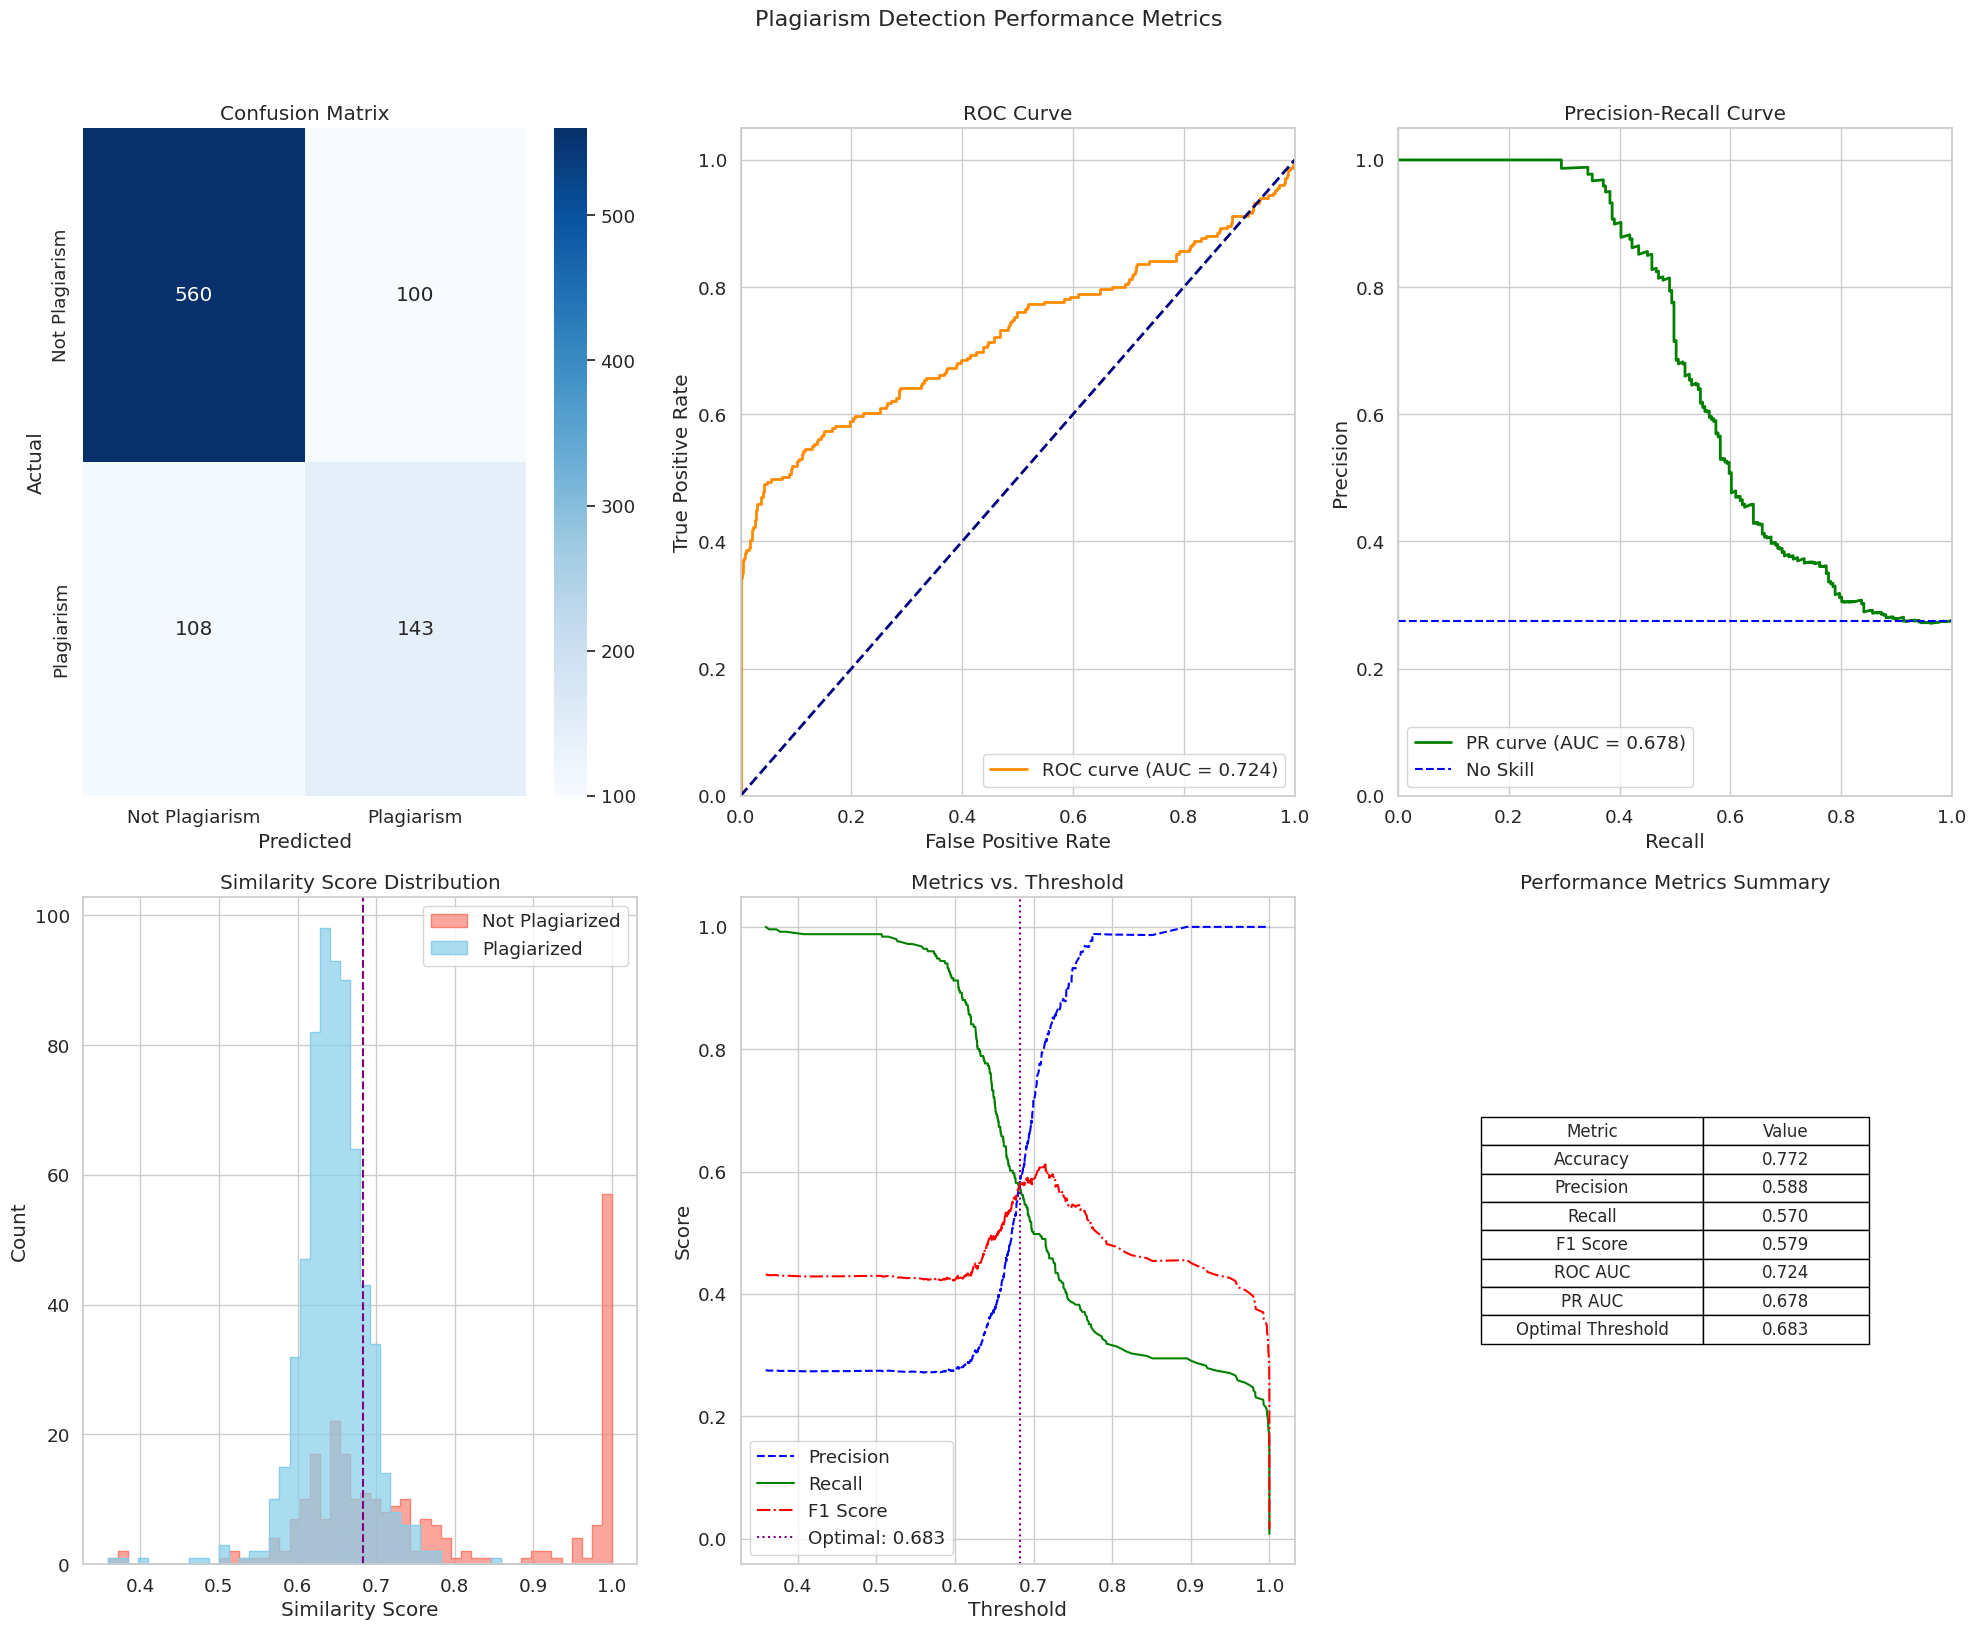

[17:48:00] INFO: Plagiarism detection pipeline completed


In [39]:
results = detector.run(
    labels_file=labels_file, batch_size=Config.BATCH_SIZE, max_items=None
)

In [40]:
metrics = results["metrics"]
print("\nResults Summary:")
print(f"  Accuracy:   {metrics['accuracy']:.4f}")
print(f"  Precision:  {metrics['precision']:.4f}")
print(f"  Recall:     {metrics['recall']:.4f}")
print(f"  F1 Score:   {metrics['f1']:.4f}")
print(f"  ROC AUC:    {metrics['roc_auc']:.4f}")
print(f"  PR AUC:     {metrics['pr_auc']:.4f}")
print(f"  Optimal Threshold: {results['optimal_threshold']:.4f}")


Results Summary:
  Accuracy:   0.7717
  Precision:  0.5885
  Recall:     0.5697
  F1 Score:   0.5789
  ROC AUC:    0.7244
  PR AUC:     0.6777
  Optimal Threshold: 0.6829
